In [2]:
import os
import cv2
import glob
import shutil
import warnings
import matplotlib.pyplot as plt
from PIL import Image

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

In [3]:
# warngin 무시
warnings.filterwarnings(action = 'ignore')

In [4]:
# 현재 실행 파일 경로 확인
os.getcwd()

'/Users/toad/Documents/ToyProject/car_detection/code'

In [5]:
root = '/Users/toad/Documents/ToyProject/car_detection'

# Preparing Dataset

* 데이터 라벨링 변경  
    각각의 차 종류 -> 차로 통일

In [ ]:
# 원본 라벨링 파일
origin_label = f'{root}/data/*.txt'
labels = glob.glob(origin_label)

print(f'Label Count : {len(labels)}')

Label Count : 1995


In [9]:
# 수정된 라벨을 저장할 디렉토리 경로 정의
edit_labels_dir = f'{root}/data/edit_labels'

if not os.path.exists(edit_labels_dir):
    os.mkdir(edit_labels_dir)

# Edit labeling data

* 모들 데이터 라벨을 "car"로 변경
* 기존 Labelme 형태를 yolo format으로 변경

In [ ]:
for label in labels:
    # 편집 후 저장을 위한 라벨 넘버 추출
    label_num = os.path.splitext(os.path.basename(label))[0]
    img_width, img_height = Image.open(f'{root}/data/{label_num}.png').size

    # 파일 열기
    with open(f'{label}', 'r', encoding = 'utf-8') as f:
        lines = f.readlines()
        
    # 라벨 데이터 처리
    new_label = "" # 저장될 값
    for line in lines:
        nums = line.strip().split()
        # print(nums)
        x_min, x_max, y_min, y_max = float(nums[1]), float(nums[3]), float(nums[2]), float(nums[6])
        # print(x_min, x_max, y_min, y_max)
        x = (x_min + x_max) / 2
        y = (y_min + y_max) / 2
        w = x_max - x_min
        h = y_max - y_min

        x = x / img_width
        y = y / img_height
        w = w / img_width
        h = h / img_height
        # print(x, y, w, h)
        new_line = f'0 {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n'
        new_label = new_label + new_line

    with open(f'{root}/data/edit_labels/{label_num}.txt', 'w', encoding = 'utf-8') as f:
        f.writelines(new_label)

# Check Edited Label

In [77]:
def draw_boxes_on_image(image_path : str, annotation_path : str,
                        img_width : int, img_height : int):
    ''' 이미지와 바운딩 박스를 그리는 함수
    Args:
        image_path (str): 이미지 파일 경로
        annotation_path (str): 라벨 파일 경로 (.txt)
        img_width (int): 이미지의 너비
        img_height (int): 이미지의 높이
    Returns:
        show image: 이미지와 바운딩 박스가 그려진 이미지
    '''

    # 이미지 불러오기
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # txt 파일에서 Class ID와 Bounding Box 정보 읽기
    with open(annotation_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        values = list(map(float, line.strip().split(' ')))
        class_id = int(values[0])

        # YOLO 형식의 좌표를 원래 이미지 크기에 맞게 변환
        x_center = values[1] * img_width
        y_center = values[2] * img_height
        box_width = values[3] * img_width
        box_height = values[4] * img_height

        # 좌표 계산
        x_min = int(round(x_center - (box_width / 2)))
        y_min = int(round(y_center - (box_height / 2)))
        x_max = int(round(x_center + (box_width / 2)))
        y_max = int(round(y_center + (box_height / 2)))

        # 이미지에 바운딩 박스 그리기
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        cv2.putText(image, str(class_id), (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # 이미지와 바운딩 박스 출력
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')  # 축 숨기기
    plt.show()


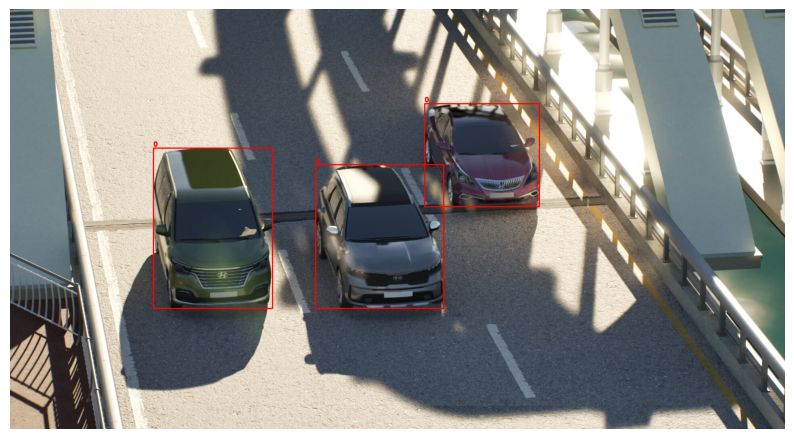

In [96]:
#### 검증 함수 실행!!
label_num = 'syn_00700'
image_file = os.path.join(f'{root}/data', label_num+'.png')
annotation_file = os.path.join(f'{root}/data/edit_labels', label_num+'.txt')
img_width, img_height = Image.open(image_file).size

draw_boxes_on_image(image_file, annotation_file, img_width, img_height)

# Split Data

* Train : Validation : Test = 6 : 2 : 2

In [17]:
origin_label = f'{root}/data/edit_labels/*.txt'
labels = glob.glob(origin_label)
labels = [os.path.splitext(os.path.basename(label))[0] for label in labels]
print('Data Count : ', len(labels))

Data Count :  1995


In [19]:
train, valid = train_test_split(labels, test_size=0.4, random_state=2025) 
valid, test = train_test_split(valid, test_size=0.5, random_state=2025)

print(f'Train : Valid : Test = {len(train)} : {len(valid)} : {len(test)}')

Train : Valid : Test = 1197 : 399 : 399


# Reconstruct Data Directory

```
└── datasets /
    ├── images /
        ├── train /
            ├── 1.png
            ├── 2.png
        ├── val /
            ├── 3.png
            ├── 4.png
        ├── test /
            ├── 5.png
            ├── 6.png
    ├── labels /
        ├── train /
            ├── 1.txt
            ├── 2.txt
        ├── val /
            ├── 3.txt
            ├── 4.txt
        ├── test /
            ├── 5.txt
            ├── 6.txt
```

In [23]:
data_dict = {
    'train' : train,
    'val' : valid,
    'test' : test
}

for split_name, data_list in data_dict.items():
    for data_num in data_list:
        img_src = f'{root}/data/{data_num}.png'
        label_src = f'{root}/data/edit_labels/{data_num}.txt'

        img_dst = f'{root}/dataset/images/{split_name}/{data_num}.png'
        label_dst = f'{root}/dataset/labels/{split_name}/{data_num}.txt'

        shutil.copy(img_src, img_dst)
        shutil.copy(label_src, label_dst)

Dataset 확인

In [29]:
train_images = glob.glob(f'{root}/dataset/images/train/*.png')
valid_images = glob.glob(f'{root}/dataset/images/val/*.png')
test_images = glob.glob(f'{root}/dataset/images/test/*.png')

train_labels = glob.glob(f'{root}/dataset/labels/train/*.txt')
valid_labels = glob.glob(f'{root}/dataset/labels/val/*.txt')
test_labels = glob.glob(f'{root}/dataset/labels/test/*.txt')

print(f'Images count : {len(train_images)}, {len(valid_images)}, {len(test_images)}')
print(f'Labels count : {len(train_labels)}, {len(valid_labels)}, {len(test_labels)}')

Images count : 1197, 399, 399
Labels count : 1197, 399, 399


.yaml 파일 만들기

In [39]:
yaml_content = f'''names:
- car
nc: 1
path: "{root}/dataset"
test: "{root}/dataset/images/test"
train: "{root}/dataset/images/train"
val: "{root}/dataset/images/val"
'''

with open(f'{root}/data.yaml', 'w') as f:
    f.write(yaml_content)

In [42]:
import yaml
with open(f'{root}/data.yaml', 'r') as f:
    data = yaml.full_load(f)
print(data)

{'names': ['car'], 'nc': 1, 'path': '/Users/toad/Documents/ToyProject/car_detection/dataset', 'test': '/Users/toad/Documents/ToyProject/car_detection/dataset/images/test', 'train': '/Users/toad/Documents/ToyProject/car_detection/dataset/images/train', 'val': '/Users/toad/Documents/ToyProject/car_detection/dataset/images/val'}
